<a href="https://colab.research.google.com/github/Nigouz/3204-CourseWork2/blob/main/Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import os
import re
from sklearn import preprocessing
import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
%matplotlib inline
plt.style.use('ggplot')
full_df = pd.read_csv(r"shuffled-noIPV6.csv")
# full_df = pd.read_csv(r"fortf.csv")

print(f"[*] Shape of dataset: {full_df.shape}")
from sklearn.utils import shuffle
full_df.drop(full_df.columns[0], axis=1, inplace=True)
full_df = shuffle(full_df)

print(full_df.tail())
print("\n")

[*] Shape of dataset: (98274, 15)
         @timestamp           src_ip src_port           dst_ip dst_port  \
51699  1.666692e+09      10.32.4.176    46418    10.132.100.52       80   
8378   1.666692e+09    100.64.19.103    44618     100.64.19.22     8443   
85482  1.666580e+09  192.168.207.142        0                0        0   
66319  1.666580e+09  192.168.207.142        0                0        0   
42154  1.666542e+09    192.168.106.1    53826  192.168.106.130       53   

                                                Protocol http_request_method  \
51699                                                TCP                   0   
8378                                                 TCP                   0   
85482                                              HTTPS                 GET   
66319                                              HTTPS                 GET   
42154  2022-10-24 00:20:51 ALLOW UDP 192.168.106.1 19...                 UDP   

      http_request_referrer http_r

In [4]:
full_df["src_port"]=  full_df["src_port"].replace(regex=",", value= "")
full_df["src_port"]=  full_df["src_port"].replace(regex=",", value= "")
full_df["dst_port"]=  full_df["dst_port"].replace(regex=",", value= "")
full_df["dst_port"]=  full_df["dst_port"].replace(regex=" ", value= "")
full_df["src_port"] = full_df["src_port"].replace(regex=" ", value="")
full_df["src_port"] = full_df["src_port"].replace(regex="dns", value="53")
full_df["src_port"] = full_df["src_port"].replace(regex="tls", value="0")
full_df["dst_port"] = full_df["dst_port"].replace(regex="dns", value="53")
full_df["dst_ip"] = full_df["dst_ip"].replace(regex="\S*:+\S+", value="0")

In [5]:
from sklearn import metrics

models = []
accuracy_dict = {}
precision_dict = {}
cm_dict = {}
recall_dict = {}
f1_dict = {}


def scoring_metrics(y_test, y_pred, model):
    models.append(model)
    print(f"y_test size:{y_test.size} y_pred size:{y_pred.size}")
    accuracy_dict[model] = metrics.accuracy_score(y_test, y_pred)
    cm_dict[model] = metrics.confusion_matrix(y_test, y_pred, labels=['nmap_scan', 'port_scan', 'smtp_enumeration', 'sql_enumeration', 'web_enumeration'])
    precision_dict[model] = metrics.precision_score(y_test, y_pred, average="weighted")
    recall_dict[model] = metrics.recall_score(y_test, y_pred, average="weighted")
    f1_dict[model] = metrics.f1_score(y_test, y_pred, average="weighted")


    print(f"\n[*] Model: {model}")
    print(f"Confusion Matrix: {metrics.confusion_matrix(y_test, y_pred, labels=['nmap_scan', 'port_scan', 'smtp_enumeration', 'sql_enumeration', 'web_enumeration'])}")
    print("[*] Precision: {:.3f}%".format(metrics.precision_score(y_test, y_pred, average="weighted")))
    print("[*] Recall: {:.3f}%".format(metrics.recall_score(y_test, y_pred, average="weighted")))
    print("[*] Accuracy: {:.3f}%".format(metrics.accuracy_score(y_test, y_pred)))
    print("[*] F1_score: {:.3f}%".format(metrics.f1_score(y_test, y_pred, average="weighted")))


# KNN

In [6]:
# df = full_df.head(25000)
df = full_df.head(10000)

In [7]:
print("Doing")
from sklearn.preprocessing import OneHotEncoder
df.replace(to_replace=["None"], value=np.nan, inplace=True)
clean_df = df.fillna(str(0)) #uhm i dont knowhow to explain this, but please lmk another alternative to fix this cause :") try to run it without str and you will know what i mean"
clean_x = clean_df.iloc[:, :13].values
clean_y = clean_df["category"].values
features = df.columns.values[:-1]

for label in clean_df.columns:
    for index, rows in clean_df.iterrows():
        new_ip = ""
        ip = str(rows[label])
        if re.search("\d+\.\d+\.\d+\.\d+", ip):
            octets = ip.split(".")
            for octet in octets:
                octet = octet.rjust(3,"0")
                new_ip += octet
            clean_df[label][index] = new_ip

clean_df["http_response_code"] = clean_df["http_response_code"].replace('HTTP/1.1"', value="0")
clean_df["src_ip"] = clean_df["src_ip"].replace('::1', value="0")
clean_df["dst_ip"] = clean_df["dst_ip"].replace('::1', value="0")
# clean_df["http_response_code"] = clean_df["http_response_code"].replace('HTTP/1.1"', value="0")
print("Done")

Doing


C:\Users\kahow\anaconda3\lib\site-packages\pandas\core\frame.py:4166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(
<ipython-input-7-1a07f9aa920b>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df[label][index] = new_ip


Done


In [8]:
from sklearn.compose import make_column_transformer
clean_x = clean_df.iloc[:, :13] #honestly don't know if this is correct lmaoooo
#this is to iterate through the columns and convert the strings to float (passthrough means for those columns we didnt specify, leave it as it is)
column_trans = make_column_transformer((OneHotEncoder(sparse=False), ['Protocol', 'http_request_method', 'http_request_referrer', 'url_path', 'user_agent_original', 'sql_method', 'sql_query']),remainder='passthrough')
test = column_trans.fit_transform(clean_x) #this is technically our cl

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
x_train, x_test, y_train, y_test = train_test_split(test, clean_y, test_size=0.3)
# x_variable_train , x_variable_test , y_variable_train , y_variable_test  = train_test_split(test, clean_y, test_size=0.3)

In [10]:
model_score = {}

# range_k = range(100, 160, 11)
range_k = range(100, 160, 11)

skip = False


for k in range_k:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train, y_train)
#     pickle.dump(knn, open(f"knn{k}.sav", "wb"))

    y_pred = knn.predict(x_test)
    scoring_metrics(y_test, y_pred, f"knn {k}")
    

y_test size:3000 y_pred size:3000

[*] Model: knn 100
Confusion Matrix: [[ 248    0    0    0    1]
 [   0 1479    0    6   10]
 [   0    3    0    0    9]
 [   0    1    0  379    0]
 [   0    4    0   12  847]]
[*] Precision: 0.980%
[*] Recall: 0.984%
[*] Accuracy: 0.984%
[*] F1_score: 0.982%


C:\Users\kahow\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


y_test size:3000 y_pred size:3000

[*] Model: knn 111
Confusion Matrix: [[ 248    0    0    0    1]
 [   0 1479    0    6   10]
 [   0    3    0    0    9]
 [   0   35    0  345    0]
 [   0    4    0   12  847]]
[*] Precision: 0.969%
[*] Recall: 0.973%
[*] Accuracy: 0.973%
[*] F1_score: 0.971%


C:\Users\kahow\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


y_test size:3000 y_pred size:3000

[*] Model: knn 122
Confusion Matrix: [[ 248    0    0    0    1]
 [   0 1479    0    6   10]
 [   0    3    0    0    9]
 [   0   35    0  345    0]
 [   0    4    0   12  847]]
[*] Precision: 0.969%
[*] Recall: 0.973%
[*] Accuracy: 0.973%
[*] F1_score: 0.971%


C:\Users\kahow\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


y_test size:3000 y_pred size:3000

[*] Model: knn 133
Confusion Matrix: [[ 248    0    0    0    1]
 [   0 1476    0    6   13]
 [   0    3    0    0    9]
 [   0   35    0  345    0]
 [   0   15    0    1  847]]
[*] Precision: 0.968%
[*] Recall: 0.972%
[*] Accuracy: 0.972%
[*] F1_score: 0.970%


C:\Users\kahow\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


y_test size:3000 y_pred size:3000

[*] Model: knn 144
Confusion Matrix: [[ 248    0    0    0    1]
 [   0 1476    0    6   13]
 [   0    3    0    0    9]
 [   0   35    0  345    0]
 [   0   15    0    1  847]]
[*] Precision: 0.968%
[*] Recall: 0.972%
[*] Accuracy: 0.972%
[*] F1_score: 0.970%


C:\Users\kahow\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


y_test size:3000 y_pred size:3000

[*] Model: knn 155
Confusion Matrix: [[ 248    0    0    0    1]
 [   0 1465    0   10   20]
 [   0    0    0    0   12]
 [   0   35    0  345    0]
 [   0   12    0    1  850]]
[*] Precision: 0.965%
[*] Recall: 0.969%
[*] Accuracy: 0.969%
[*] F1_score: 0.967%


C:\Users\kahow\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [11]:
# import seaborn as sb
# confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
# fig, ax = plt.subplots(figsize=(11, 9))
# # sb.heatmap(confusion_matrix/np.sum(confusion_matrix), annot=True, fmt='.2%', cmap='Blues')
# sb.heatmap(confusion_matrix, annot=True, fmt='0', cmap='Blues')

# plt.show()


In [12]:
models = [100, 111, 122, 133, 144, 155]
accuracy_dict

{'knn 100': 0.9843333333333333,
 'knn 111': 0.973,
 'knn 122': 0.973,
 'knn 133': 0.972,
 'knn 144': 0.972,
 'knn 155': 0.9693333333333334}

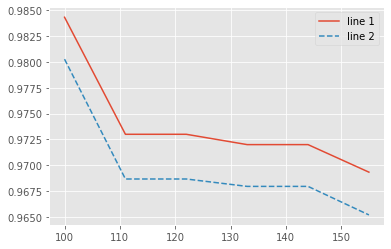

In [13]:
plt.plot(models, list(accuracy_dict.values()), label = "accuracy_dict", linestyle="-")
plt.plot(models, list(precision_dict.values()), label = "precision_dict", linestyle="--")
plt.legend()
plt.show()


In [16]:
list(precision_dict.values())

[0.9802735714499149,
 0.9686707030285813,
 0.9686707030285813,
 0.9679545111356977,
 0.9679545111356977,
 0.965192309909063]